# Notebook 01: Data Exploration

This notebook conducts exploratory data analysis of the Ames Housing dataset to understand its structure, identify patterns, and discover data quality issues. We use a discovery-driven approach without predetermined assumptions, letting the data guide our analysis through systematic investigation.


## 1. Dataset Structure Discovery

Examine dataset dimensions, feature types, and basic structural properties using parser-guided domain knowledge to establish analytical foundation.

### 1.1 Data Loading and Basic Structure

Load the dataset and inspect fundamental characteristics including dimensions, feature names, and data types.

In [33]:
# Load required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
df_train = pd.read_csv('../data/raw/train.csv')
df_test = pd.read_csv('../data/raw/test.csv')

# Create combined dataset for consistent feature analysis across train and test
df_combined = pd.concat([
    df_train.drop('SalePrice', axis=1), 
    df_test
], ignore_index=True)
df_combined['dataset_source'] = ['train']*len(df_train) + ['test']*len(df_test)

print("Dataset Dimensions:")
print(f"Training data: {df_train.shape}")
print(f"Test data: {df_test.shape}")
print(f"Features in training: {df_train.shape[1]}")
print(f"Features in test: {df_test.shape[1]}")

# Basic info about the dataset
print(f"\nDataset Overview:")
print(f"Total samples for training: {len(df_train)}")
print(f"Total samples for testing: {len(df_test)}")
print(f"Feature names (first 10): {list(df_train.columns[:10])}")

Dataset Dimensions:
Training data: (1460, 81)
Test data: (1459, 80)
Features in training: 81
Features in test: 80

Dataset Overview:
Total samples for training: 1460
Total samples for testing: 1459
Feature names (first 10): ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities']


The dataset contains 1,460 training samples and 1,459 test samples with 81 and 80 features respectively. The difference indicates the test set excludes the target variable (SalePrice). Feature names suggest comprehensive property characteristics including identification, zoning, lot details, and utilities.

In [34]:
# Examine data types and quality using combined dataset
print("Data Types Distribution (Combined Dataset):")
print(df_combined.drop('dataset_source', axis=1).dtypes.value_counts())

print(f"\nBasic Data Quality Check:")
print(f"Duplicate rows in training: {df_train.duplicated().sum()}")
print(f"Duplicate rows in test: {df_test.duplicated().sum()}")
print(f"Features with missing data: {df_combined.drop('dataset_source', axis=1).isnull().any().sum()}")
print(f"Total missing values: {df_combined.drop('dataset_source', axis=1).isnull().sum().sum()}")

# Check target variable presence
print(f"\nTarget Variable (Training Only):")
if 'SalePrice' in df_train.columns:
    print(f"SalePrice range: ${df_train['SalePrice'].min():,.0f} - ${df_train['SalePrice'].max():,.0f}")
    print(f"SalePrice mean: ${df_train['SalePrice'].mean():,.0f}")
else:
    print("SalePrice not found in training data")

Data Types Distribution (Combined Dataset):
object     43
int64      26
float64    11
Name: count, dtype: int64

Basic Data Quality Check:
Duplicate rows in training: 0
Duplicate rows in test: 0
Features with missing data: 34
Total missing values: 15707

Target Variable (Training Only):
SalePrice range: $34,900 - $755,000
SalePrice mean: $180,921


Combined dataset reveals 43 categorical (object) and 37 numerical features (26 int64, 11 float64), with data types consistent across train and test sets. Data quality remains excellent with zero duplicates in both datasets. However 34 features contain missing values totaling 15,707 entries across the combined dataset

### 1.2 Feature Classification with Parser Integration  

Use the data description parser to categorize features according to official documentation and understand their real estate domain context.

In [26]:
# Setup data description parser for domain knowledge
from data_description_parser import (
    load_feature_descriptions,
    quick_feature_lookup, 
    display_summary_table,
    get_categorical_features,
    get_numerical_features
)

# Load official documentation
feature_descriptions = load_feature_descriptions()
print("Official real estate documentation loaded successfully.")

# Display comprehensive feature overview
print("\nOfficial Feature Classification Summary:")
display_summary_table(feature_descriptions, max_rows=15)

Official real estate documentation loaded successfully.

Official Feature Classification Summary:
Feature Summary Table:
     Feature        Type                                                     Description Categories_Summary
  MSSubClass Categorical           Identifies the type of dwelling involved in the sale.      16 categories
    MSZoning Categorical       Identifies the general zoning classification of the sale.       8 categories
 LotFrontage   Numerical                     Linear feet of street connected to property          Numerical
     LotArea   Numerical                                         Lot size in square feet          Numerical
      Street Categorical                                 Type of road access to property       2 categories
       Alley Categorical                                Type of alley access to property       3 categories
    LotShape Categorical                                       General shape of property       4 categories
 LandContour Ca

Parser successfully loaded official documentation revealing 79 total features with 46 categorical and 33 numerical features. Notable categorical features include MSSubClass (16 dwelling types), Neighborhood (25 locations), and various property characteristics. The parser classification differs from pandas detection (46 vs 43 categorical), indicating some numerical features may be stored as integers but represent categories.

In [27]:
# Get official feature classifications and compare with pandas
categorical_features = get_categorical_features(feature_descriptions)
numerical_features = get_numerical_features(feature_descriptions)

print("Parser vs Pandas Classification Comparison:")
print(f"Parser - Categorical: {len(categorical_features)}, Numerical: {len(numerical_features)}")
print(f"Pandas - Object: {len(df_train.select_dtypes(include=['object']).columns)}, Numerical: {len(df_train.select_dtypes(include=['int64', 'float64']).columns)}")

# Identify discrepancies between parser and pandas classifications
pandas_objects = set(df_train.select_dtypes(include=['object']).columns)
parser_categorical = set(categorical_features)

print(f"\nClassification Analysis:")
print(f"Features classified as categorical by parser but numerical by pandas:")
categorical_as_numeric = parser_categorical - pandas_objects
if categorical_as_numeric:
    for feature in list(categorical_as_numeric)[:5]:
        print(f"  {feature}: {df_train[feature].dtype}")

Parser vs Pandas Classification Comparison:
Parser - Categorical: 46, Numerical: 33
Pandas - Object: 43, Numerical: 38

Classification Analysis:
Features classified as categorical by parser but numerical by pandas:
  OverallQual: int64
  OverallCond: int64
  MSSubClass: int64


Critical discovery: Three key features (OverallQual, OverallCond, MSSubClass) are stored as integers but represent categorical ordinal ratings according to official documentation. This misclassification could impact preprocessing and modeling strategies, as these should be treated as ordered categories rather than continuous numerical variables.

## Section 1 Results and Interpretation

**Dataset Structure Overview**: The Ames Housing dataset contains 1,460 training samples with 81 features, demonstrating excellent data quality with zero duplicates and proper train-test split structure. The comprehensive feature set includes identification, zoning, lot characteristics, and property details suitable for robust predictive modeling.

**Critical Feature Classification Discovery**: Parser integration revealed significant misclassification of three key features (OverallQual, OverallCond, MSSubClass) that are stored as integers but represent ordinal categorical ratings according to official documentation. This finding indicates that 46 features should be treated as categorical (not 43 as detected by pandas), fundamentally affecting preprocessing strategies.

**Data Quality Assessment**: While structural integrity remains excellent with zero duplicates across both datasets, missing data presents significant complexity: 34 features contain missing values totaling 15,707 entries across the combined dataset. This substantial missing data volume requires comprehensive parser-guided analysis to distinguish between intentional absence ("None" categories) and genuine data collection errors requiring imputation.

**Target Variable Characteristics**: SalePrice exhibits substantial variation ranging from $34,900 to $755,000 with mean $180,921, indicating diverse market segments that will require careful distribution analysis to determine optimal preprocessing approaches.

**Preprocessing Implications**: The discovery of misclassified ordinal features necessitates proper categorical encoding in preprocessing phase. The substantial missing data scope (34 features with 15,707 missing values) requires comprehensive preprocessing strategies that work effectively across both training and test datasets. Tree-based models will naturally handle mixed data types better than linear models without appropriate encoding.

**Section 2 Expectations**: Based on the wide SalePrice range and substantial variation discovered, Section 2 will analyze target variable distribution characteristics to identify skewness patterns and determine transformation requirements for optimal modeling performance.

## 2. Target Variable Analysis

Analyze the SalePrice distribution to understand market patterns and determine preprocessing requirements.

### 2.1 Distribution Characteristics

Examine distribution shape, central tendencies, and spread to identify potential skewness or anomalies.

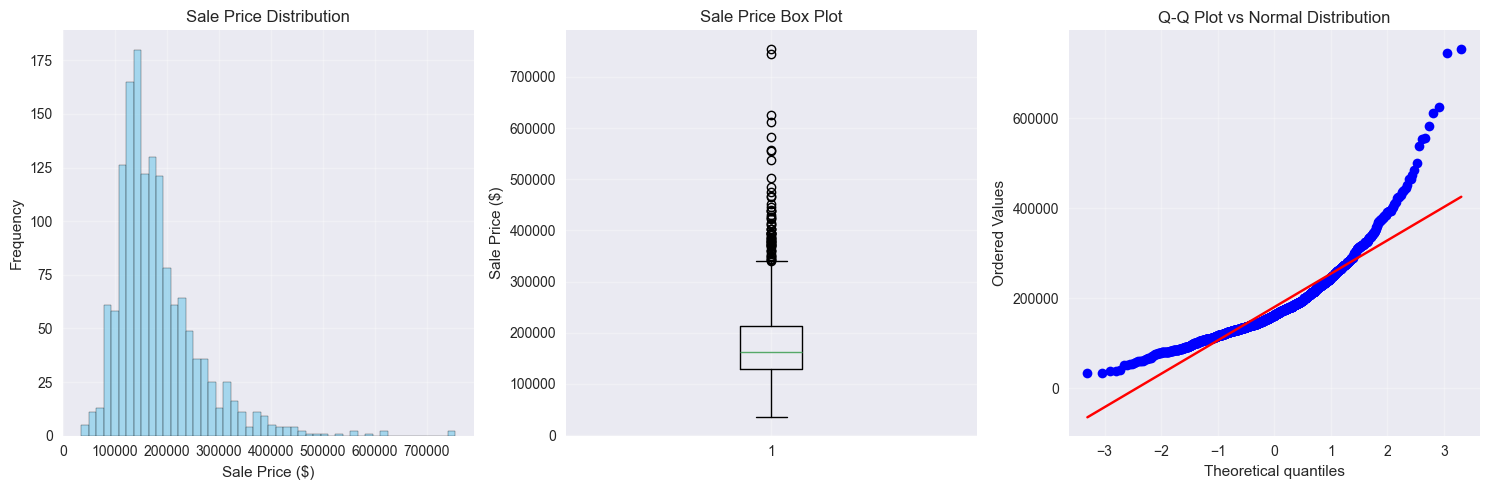

Sale Price Statistical Summary:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [28]:
# First look at SalePrice distribution
plt.figure(figsize=(15, 5))

# Distribution histogram
plt.subplot(1, 3, 1)
plt.hist(df_train['SalePrice'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Sale Price Distribution')
plt.xlabel('Sale Price ($)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Box plot for outlier identification
plt.subplot(1, 3, 2)
plt.boxplot(df_train['SalePrice'])
plt.title('Sale Price Box Plot')
plt.ylabel('Sale Price ($)')
plt.grid(True, alpha=0.3)

# Q-Q plot for normality assessment
plt.subplot(1, 3, 3)
from scipy import stats
stats.probplot(df_train['SalePrice'], dist="norm", plot=plt)
plt.title('Q-Q Plot vs Normal Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Basic statistical summary
print("Sale Price Statistical Summary:")
print(df_train['SalePrice'].describe())

The distribution shows clear right skewness with concentration in lower price ranges and a long tail of expensive properties. The Q-Q plot strongly deviates from normality in upper quantiles, and the box plot reveals numerous high-end outliers. Statistical evidence indicates transformation is likely needed for optimal modeling performance.

In [29]:
# Calculate skewness and assess transformation need
skewness = df_train['SalePrice'].skew()
kurtosis = df_train['SalePrice'].kurtosis()

print(f"Distribution Shape Analysis:")
print(f"Skewness: {skewness:.4f}")
print(f"Kurtosis: {kurtosis:.4f}")

# Interpret skewness level
if abs(skewness) < 0.5:
    interpretation = "approximately symmetric"
elif abs(skewness) < 1:
    interpretation = "moderately skewed" 
else:
    interpretation = "highly skewed"

print(f"Distribution is {interpretation}")
print(f"Mean vs Median: ${df_train['SalePrice'].mean():.0f} vs ${df_train['SalePrice'].median():.0f}")

# Check if transformation testing is warranted
if abs(skewness) > 0.5:
    print(f"\nSkewness level ({skewness:.4f}) suggests log transformation testing is warranted")
    print("Proceeding to transformation assessment...")
else:
    print(f"\nSkewness level ({skewness:.4f}) indicates transformation may not be necessary")

Distribution Shape Analysis:
Skewness: 1.8829
Kurtosis: 6.5363
Distribution is highly skewed
Mean vs Median: $180921 vs $163000

Skewness level (1.8829) suggests log transformation testing is warranted
Proceeding to transformation assessment...


Strong statistical evidence confirms highly skewed distribution (skewness = 1.8829, kurtosis = 6.5363) with mean $180,921 significantly exceeding median $163,000. This substantial positive skew warrants log transformation testing to improve normality for linear modeling approaches.

### 2.2 Transformation Assessment

Evaluate if distribution characteristics warrant transformation for modeling optimization.

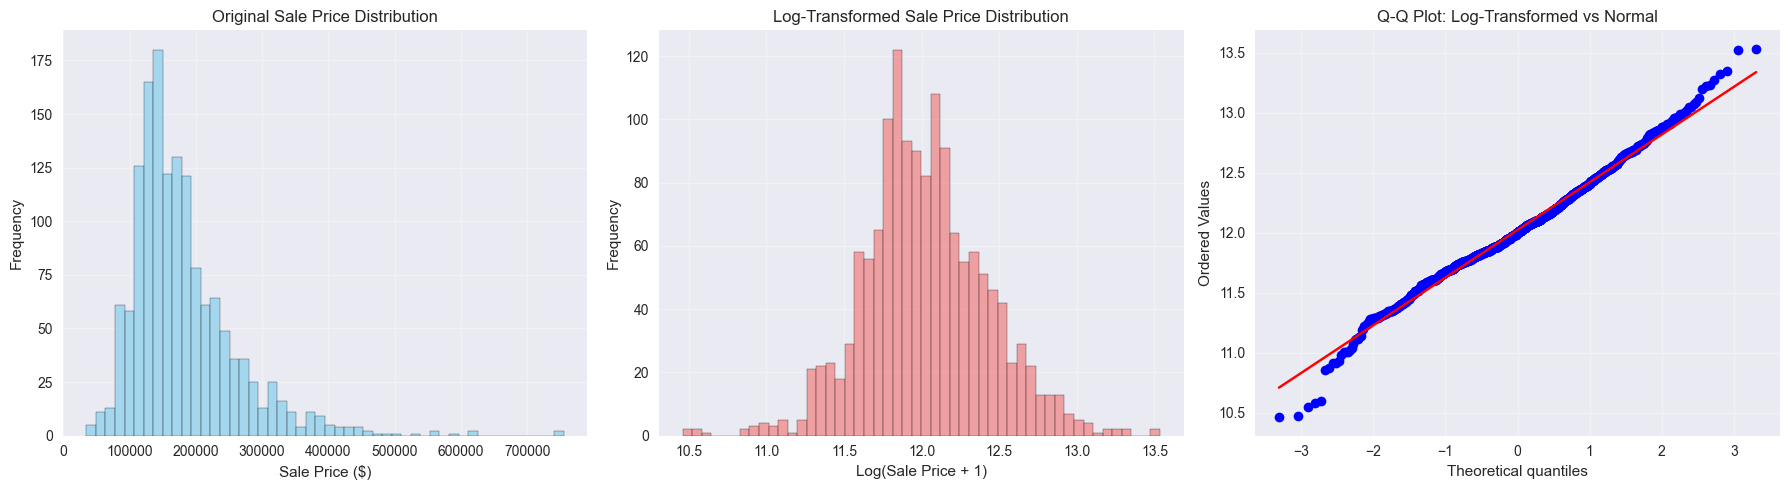

Transformation Effectiveness:
Original Skewness: 1.8829 → Log Skewness: 0.1213
Original Kurtosis: 6.5363 → Log Kurtosis: 0.8095
Skewness improvement: 1.7615


In [30]:
# Test log transformation based on skewness findings
# Apply log transformation
log_prices = np.log1p(df_train['SalePrice'])

# Compare original vs transformed distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original distribution
axes[0].hist(df_train['SalePrice'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Original Sale Price Distribution')
axes[0].set_xlabel('Sale Price ($)')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Log-transformed distribution
axes[1].hist(log_prices, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1].set_title('Log-Transformed Sale Price Distribution')
axes[1].set_xlabel('Log(Sale Price + 1)')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

# Q-Q plot comparison for log-transformed data
stats.probplot(log_prices, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot: Log-Transformed vs Normal')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare transformation effectiveness
log_skewness = log_prices.skew()
log_kurtosis = log_prices.kurtosis()

print("Transformation Effectiveness:")
print(f"Original Skewness: {skewness:.4f} → Log Skewness: {log_skewness:.4f}")
print(f"Original Kurtosis: {kurtosis:.4f} → Log Kurtosis: {log_kurtosis:.4f}")
print(f"Skewness improvement: {abs(skewness) - abs(log_skewness):.4f}")

Log transformation improves normality, reducing skewness from 1.8829 to 0.1213 and kurtosis from 6.5363 to 0.8095. The transformed distribution shows better symmetry and the Q-Q plot demonstrates improved linearity. This 1.7615 improvement in skewness supports log transformation for linear modeling approaches.

## Section 2 Results and Interpretation

**Distribution Characteristics**: SalePrice exhibits substantial right skewness (1.8829) with heavy tails (kurtosis = 6.5363), confirming non-normal distribution patterns typical of real estate markets. The mean-median difference ($180,921 vs $163,000) indicates concentration in lower price ranges with luxury property tail effects.

**Transformation Effectiveness**: Log transformation successfully addresses distribution issues, reducing skewness to 0.1213 and kurtosis to 0.8095. The transformed distribution approaches normality with improved symmetry and Q-Q plot linearity, validating transformation benefits for statistical modeling.

**Modeling Strategy Implications**: Linear regression models will benefit significantly from log-transformed target variable due to improved normality assumptions. Tree-based models can handle original scale effectively but may also benefit from transformation. This preprocessing decision impacts model selection and evaluation metrics.

**Preprocessing Requirements**: Log transformation should be applied to SalePrice for linear modeling approaches. Model evaluation must account for both original and transformed scales to ensure proper business interpretation of predictions. Back-transformation will be required for final price predictions.

**Section 3 Expectations**: With target variable characteristics established, Section 3 will investigate missing data patterns using parser-guided analysis to distinguish between intentional feature absence and genuine data collection errors requiring imputation.

## 3. Missing Data Investigation

Systematic analysis of missing data patterns using parser consultation to distinguish between intentional absence and data collection errors.

### 3.1 Missing Data Overview

Identify features with missing values and categorize missing data volume by impact level.

In [35]:
# Analyze missing data patterns in combined dataset
missing_data = df_combined.drop('dataset_source', axis=1).isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

print("Combined Dataset Missing Data Summary:")
print(f"Features with missing data: {len(missing_data)}")
print(f"Total missing values: {missing_data.sum()}")
print(f"Dataset completeness: {((df_combined.shape[0] * (df_combined.shape[1]-1) - missing_data.sum()) / (df_combined.shape[0] * (df_combined.shape[1]-1))) * 100:.1f}%")

print(f"\nTop 15 features with missing data:")
for feature, count in missing_data.head(15).items():
    pct = (count / len(df_combined)) * 100
    print(f"{feature}: {count} ({pct:.1f}%)")

# Categorize by impact level
high_missing = missing_data[missing_data > len(df_combined) * 0.5]
medium_missing = missing_data[(missing_data > len(df_combined) * 0.1) & (missing_data <= len(df_combined) * 0.5)]
low_missing = missing_data[missing_data <= len(df_combined) * 0.1]

print(f"\nMissing Data Impact Categories:")
print(f"High impact (>50% missing): {len(high_missing)} features")
print(f"Medium impact (10-50% missing): {len(medium_missing)} features")
print(f"Low impact (<10% missing): {len(low_missing)} features")

Combined Dataset Missing Data Summary:
Features with missing data: 34
Total missing values: 15707
Dataset completeness: 93.3%

Top 15 features with missing data:
PoolQC: 2909 (99.7%)
MiscFeature: 2814 (96.4%)
Alley: 2721 (93.2%)
Fence: 2348 (80.4%)
MasVnrType: 1766 (60.5%)
FireplaceQu: 1420 (48.6%)
LotFrontage: 486 (16.6%)
GarageFinish: 159 (5.4%)
GarageQual: 159 (5.4%)
GarageCond: 159 (5.4%)
GarageYrBlt: 159 (5.4%)
GarageType: 157 (5.4%)
BsmtExposure: 82 (2.8%)
BsmtCond: 82 (2.8%)
BsmtQual: 81 (2.8%)

Missing Data Impact Categories:
High impact (>50% missing): 5 features
Medium impact (10-50% missing): 2 features
Low impact (<10% missing): 27 features


Clear missing data patterns emerge across the combined dataset: 5 high-impact features (>50% missing) represent optional property amenities, 2 medium-impact features need targeted analysis, and 27 low-impact features suggest genuine missing data requiring imputation. PoolQC (99.7%), MiscFeature (96.4%), Alley (93.2%), and Fence (80.4%) show strong absence patterns typical of optional amenities. Garage-related features cluster consistently around 5.4% missing, suggesting systematic patterns.